# Exploration of Neural Network libraries in Python:
# Training a Feedforward Neural Network for Regression

#### 1. Benchmark: Linear Regression (scikit-learn)
    Diabetes dataset

#### 2. Scikit-Neural Network (SKNN)
    2.1 Diabetes dataset
    2.2 Sine function example

#### 3. PyBrain
    3.1 Diabetes dataset - Part 1
    3.2 Diabetes dataset - Part 2
    3.3 Sine function example

#### 4. Other packages

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
import matplotlib.pyplot as plt
%matplotlib inline 
import time, math

## 1. Benchmark: Linear Regression (Scikit-learn)

Coefficients: [ 938.23786125] 152.918861826
Mean square error (MSE): 2548.07
R^2: 0.47


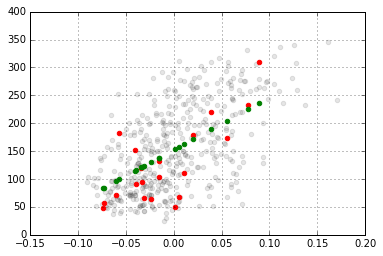

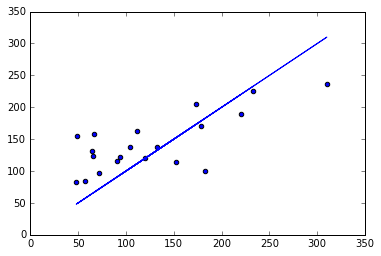

In [3]:
from sklearn import linear_model, datasets
from sklearn.cross_validation import train_test_split

# Load the diabetes dataset
diabetes = datasets.load_diabetes()
#print pd.DataFrame(diabetes.data).head()

# Use only one feature
diabetes_X = diabetes.data[:, np.newaxis] 
diabetes_X_temp = diabetes_X[:, :, 2]       # keeps only the 3rd column

# Split the data into training/testing sets
diabetes_X_train = diabetes_X_temp[:-20]
diabetes_X_test = diabetes_X_temp[-20:]

# Split the targets into training/testing sets
diabetes_y_train = diabetes.target[:-20]
diabetes_y_test = diabetes.target[-20:]

regr = linear_model.LinearRegression()              # Create linear regression object
regr.fit(diabetes_X_train, diabetes_y_train)        # Train the model using the training sets

diabetes_y_pred_lin = regr.predict(diabetes_X_test)
            
print 'Coefficients:', regr.coef_, regr.intercept_                  # The coefficients
print("Mean square error (MSE): %.2f"
      % np.mean((diabetes_y_pred_lin - diabetes_y_test) ** 2))      # The mean square error
print 'R^2: %.2f' % regr.score(diabetes_X_test, diabetes_y_test)    # Explained variance score

# Plot outputs
plt.clf() 
plt.scatter(diabetes_X_train, diabetes_y_train,  color='black', alpha=0.1)
plt.scatter(diabetes_X_test, diabetes_y_test,  color='red')
plt.scatter(diabetes_X_test, diabetes_y_pred_lin, color='green') # benchmark
plt.grid(True)
plt.show()
# Predictions against ground truth
plt.scatter(diabetes_y_test, diabetes_y_pred_lin)
plt.plot(diabetes_y_test, diabetes_y_test)
plt.show()

## 2. Scikit-Neural Network (SKNN)

See http://scikit-neuralnetwork.readthedocs.org/en/latest/guide_beginners.html

Different approach for Classification vs. Regression using Neural Network:
- Training examples: Rn x {class_1, ..., class_n} (one-hot encoding) vs Rn x Rm
- Last layer: softmax vs linear / sigmoid
- Loss function: Cross entropy vs MSE / Absolute error

In [ ]:
############ INSTALLATION of SKNN and THEANO on Windows 10 #################
#!pip install scikit-neuralnetwork
#!pip install --upgrade --no-deps git+git://github.com/Theano/Theano.git
#!conda install mingw libpython
#!conda install pydot-ng
#and install a c++ compiler: TDM GCC x64 on their website (tdm64-gcc-5.1.0-2.exe)
#Note: make sure there is only one gcc compiler in the environment PATH
############################################################################

### 2.1. SKNN: Regression (diabetes dataset)

In [27]:
from sknn.mlp import Regressor, Layer

nn0 = Regressor(layers=[# input layer is added automatically, based on the number of features
                        # a bias unit is added automatically for every input and hiddens layers
                        Layer("Rectifier", units=5),      # hidden layers: Rectifier, Sigmoid or Tanh
                        Layer("Linear", units=1)],        # output layer                           
                learning_rate=0.0001,
                weight_decay=0.01,         # weight_decay = regularization
                regularize='L2',
                learning_momentum=0.9,
                n_iter=20,
                batch_size=1,    # batch_size=1: each sample is treated on its own
                loss_type='mse',
                verbose=True)

# Normalizing data
X_max = max(diabetes_X_train)   

# fitting the model
nn0.fit(diabetes_X_train / X_max, diabetes_y_train)

print "Neural network parameters:"     
# first is param (Theta1)is between input and hidden ; last param (Theta2) is between hidden and output
for param in nn0.get_parameters():
    print param[2]
    print '\t weights: ', np.round(param[0],2)
    print '\t biases: ', np.round(param[1],2)

Neural network parameters:
hidden0
	 weights:  [[  0.66  -0.18   2.14  11.84   0.86]]
	 biases:  [ -0.42   0.08   0.46  11.47  -0.27]
output
	 weights:  [[ -0.16]
 [  0.02]
 [  1.59]
 [ 14.08]
 [  0.16]]
	 biases:  [ 3.71]


Results of SKNN Regression:
Residual sum of squares (MSE): 7812.47
Variance score: -0.15


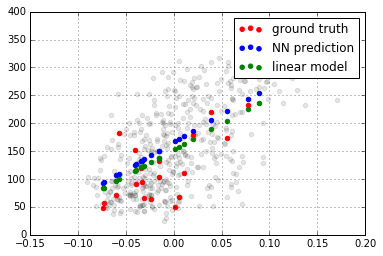

In [28]:
# Making the prediction
diabetes_y_pred0 = nn0.predict(diabetes_X_test / X_max)

# Show Results
print "Results of SKNN Regression:"
print "Residual sum of squares (MSE): %.2f" % np.mean((diabetes_y_pred0 - diabetes_y_test) ** 2)
print 'Variance score: %.2f' % nn0.score(diabetes_X_test, diabetes_y_test) # Explained variance score: 1 is perfect prediction

# Plot outputs
plt.clf() 
plt.scatter(diabetes_X_train, diabetes_y_train,  color='black', alpha=0.1)
plt.scatter(diabetes_X_test, diabetes_y_test,  color='red', label='ground truth')
plt.scatter(diabetes_X_test, diabetes_y_pred0, color='blue', label='NN prediction')     ## NN
plt.scatter(diabetes_X_test, diabetes_y_pred_lin, color='green', label='linear model')  ## Benchmark
plt.grid(True)
plt.legend()
plt.show()

#### Learning curves

In [11]:
from sklearn.learning_curve import learning_curve
from sklearn import cross_validation

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, scoring=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score: " + str(scoring))
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.gca().invert_yaxis()
    
    return plt

<module 'matplotlib.pyplot' from 'C:\Users\Nicolas\Anaconda\lib\site-packages\matplotlib\pyplot.pyc'>

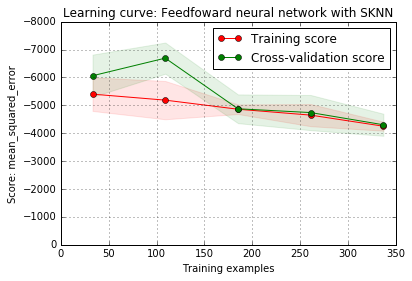

In [14]:
# plot learning curve
estimator = nn0
title = "Learning curve: Feedfoward neural network with SKNN"  
cv = 5
plot_learning_curve(estimator, title, diabetes_X_train, diabetes_y_train, 
                    ylim=(-8000., 0.), cv=cv, n_jobs=-1, scoring='mean_squared_error')

#### Validation curves

In [20]:
from sklearn.learning_curve import validation_curve

def plot_validation_curve(estimator, X, y, param_name, param_range, n_jobs=1, cv=None, scoring=None, ylim=None):
    """ Generate a simple plot of a test and traning validation curve."""
    
    train_scores, test_scores = validation_curve(estimator, X, y,
                                             param_name=param_name, param_range=param_range,
                                             cv=cv, n_jobs=n_jobs, scoring=scoring)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    if ylim is not None:
        plt.ylim(*ylim)
    plt.title("Validation Curve")
    plt.xlabel("Parameter: " + str(param_name))
    plt.ylabel("Score: " + str(scoring))
    
    #plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
    plt.plot(param_range, train_scores_mean, label="Training score", color="r")
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2, color="r")
    #plt.semilogx(param_range, test_scores_mean, label="Cross-validation score", color="g")
    plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="g")
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2, color="g")
    
    plt.legend(loc="best")
    plt.gca().invert_yaxis()
    plt.show()

In this plot you can see the training scores and validation scores of an SKNN for different values of the learning rates. 
Of course, the proper way of choosing multiple hyperparameters of an estimator are grid search or similar methods that select the hyperparameter with the maximum score on a validation set or multiple validation sets. 

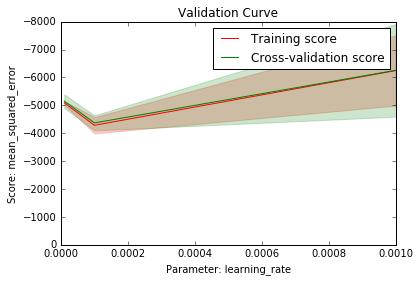

In [21]:
# plot validation curve
#param_name = "n_iter"
#param_range = [10, 20, 30]  #np.logspace(-6, -1, 5)
param_name="learning_rate"
param_range = [0.001, 0.0001, 0.00001] 
estimator = nn0
cv = 5
plot_validation_curve(estimator, diabetes_X_train, diabetes_y_train, param_name=param_name, param_range=param_range,
                    cv=cv, n_jobs=-1, scoring='mean_squared_error', ylim=(-8000., 0.))

Per the validation curve, the error is minimum for a learning_rate around 0.0001.

### 2.2. SKNN: Regression (sine function example)

Results of SKNN Regression:
Residual sum of squares (MSE): 7.91
Variance score: 0.34


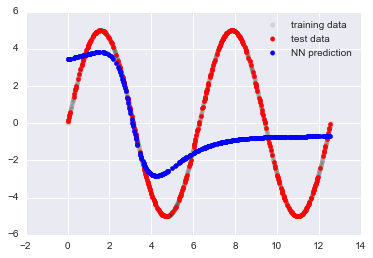

In [72]:
from sknn.mlp import Regressor, Layer
from sklearn.cross_validation import train_test_split

# Build the dataset
sine_X = np.linspace(0, 2 * 2 * math.pi, 1001)  
sine_y = 5 * np.sin(sine_X)
sine_X_train, sine_X_test, sine_y_train, sine_y_test = train_test_split(sine_X, sine_y, test_size=0.33, random_state=42)
# Transform 1D arrays to 2D arrays
sine_X_train = sine_X_train[:,None]
sine_X_test = sine_X_test[:,None]
sine_y_train = sine_y_train[:,None]
sine_y_test = sine_y_test[:,None]

# Build the NN
nn01 = Regressor(layers=[# input layer is added automatically, based on the number of features
                        # a bias unit is added automatically for every input and hiddens layers
                        Layer("Tanh", units=30),      # 1st hidden layer: Rectifier, Sigmoid or Tanh
                        Layer("Tanh", units=30),      # 2nd hidden layer: Rectifier, Sigmoid or Tanh
                        Layer("Linear", units=1)],    # output layer                           
                learning_rate=0.001,
                weight_decay=0.1,                     # weight_decay = regularization
                regularize='L2',
                learning_momentum=0.66,
                n_iter=50,
                batch_size=1,                         # batch_size=1: each sample is treated on its own
                loss_type='mse',
                verbose=True)

# Fitting the model
nn01.fit(sine_X_train, sine_y_train)

# Making the prediction
sine_y_pred = nn01.predict(sine_X_test) 

# Results
print("Results of SKNN Regression:")
print("Residual sum of squares (MSE): %.2f" % np.mean((sine_y_pred - sine_y_test) ** 2))
print('Variance score: %.2f' % nn01.score(sine_X_test, sine_y_test)) # Explained variance score: 1 is perfect prediction

# Plot outputs
plt.clf() 
plt.scatter(sine_X_train, sine_y_train,  color='black', label='training data', alpha=0.1)
plt.scatter(sine_X_test, sine_y_test,  color='red', label='test data')
plt.scatter(sine_X_test, sine_y_pred, color='blue', label='NN prediction') ## NN
plt.grid(True)
plt.legend()
plt.show()

#### Randomized Search for hyperparameter tuning

In [69]:
# Specify parameters and distributions to sample from
param_dist = {  "learning_rate"     : np.logspace(-4, -2, 3),  # 3 numbers from 1e-4 to 1e-2
                "weight_decay"      : np.logspace(-4, -2, 3),
                "learning_momentum" : [0.33, 0.66, 0.99],
                "n_iter"            : [30, 40, 50]}

# Start the Randomized Search
n_iter_search = 20
random_search = RandomizedSearchCV(nn01, param_distributions=param_dist, n_iter=n_iter_search, 
                                   scoring='mean_squared_error', n_jobs=-1, cv=3, verbose=3)

random_search = random_search.fit(sine_X_train, sine_y_train)
print "Best parameters set found on development set:"
print random_search.best_score_, random_search.best_params_
print
print "Grid scores on development set:"
for params, mean_score, scores in random_search.grid_scores_:
    print "%0.3f (+/-%0.03f) for %r" % (mean_score, scores.std() * 2, params)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.5min finished


Best parameters set found on development set:
-1.66633011538 {'n_iter': 40, 'learning_rate': 0.001, 'weight_decay': 0.01, 'learning_momentum': 0.33}

Grid scores on development set:
-9.275 (+/-1.859) for {'n_iter': 50, 'learning_rate': 0.01, 'weight_decay': 0.01, 'learning_momentum': 0.99}
-9.847 (+/-0.359) for {'n_iter': 40, 'learning_rate': 0.0001, 'weight_decay': 0.0001, 'learning_momentum': 0.99}
-10.057 (+/-3.069) for {'n_iter': 40, 'learning_rate': 0.01, 'weight_decay': 0.001, 'learning_momentum': 0.33}
-9.413 (+/-0.884) for {'n_iter': 40, 'learning_rate': 0.01, 'weight_decay': 0.001, 'learning_momentum': 0.99}
-9.805 (+/-0.627) for {'n_iter': 50, 'learning_rate': 0.0001, 'weight_decay': 0.001, 'learning_momentum': 0.33}
-8.540 (+/-0.169) for {'n_iter': 30, 'learning_rate': 0.01, 'weight_decay': 0.0001, 'learning_momentum': 0.33}
-9.918 (+/-0.089) for {'n_iter': 50, 'learning_rate': 0.0001, 'weight_decay': 0.01, 'learning_momentum': 0.99}
-9.972 (+/-0.632) for {'n_iter': 40, 'lea

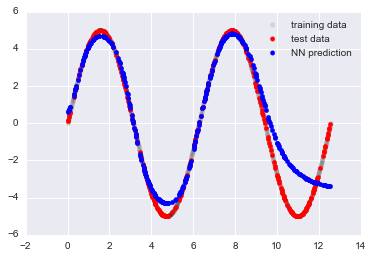

Residual sum of squares (MSE): 0.88


In [71]:
nn01_opt = Regressor(layers=[# input layer is added automatically, based on the number of features
                             # a bias unit is added automatically for every input and hiddens layers
                             Layer("Tanh", units=30),      # 1st hidden layer: Rectifier, Sigmoid or Tanh
                             Layer("Tanh", units=30),      # 2nd hidden layer: Rectifier, Sigmoid or Tanh
                             Layer("Linear", units=1)],    # output layer                           
                learning_rate=random_search.best_params_['learning_rate'],  
                weight_decay=random_search.best_params_['weight_decay'],      
                regularize='L2',
                learning_momentum=random_search.best_params_['learning_momentum'],
                n_iter=random_search.best_params_['n_iter'],
                batch_size=1,    # batch_size=1: each sample is treated on its own
                loss_type='mse',
                verbose=True)

# Fitting the model
nn01_opt.fit(sine_X_train, sine_y_train)

# Plot outputs
plt.clf() 
plt.scatter(sine_X_train, sine_y_train,  color='black', label='training data', alpha=0.1)
plt.scatter(sine_X_test, sine_y_test,  color='red', label='test data')
plt.scatter(sine_X_test, nn01_opt.predict(sine_X_test) , color='blue', label='NN prediction') ## NN
plt.grid(True)
plt.legend()
plt.show()
print "Residual sum of squares (MSE): %.2f" % np.mean((nn01_opt.predict(sine_X_test) - sine_y_test) ** 2)

#### Learning curves

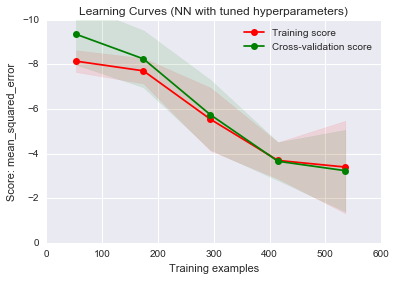

In [81]:
title = 'Learning Curves (NN with tuned hyperparameters)'    
estimator = nn01_opt # regressor with tuned hyperparameters 
plot_learning_curve(estimator, title, sine_X_train, sine_y_train, 
                    ylim=(-10., 0.), cv=5, n_jobs=-1, scoring='mean_squared_error')
plt.grid(True)
plt.show()

Note: It outputs the negative of the MSE, as it always tries to maximize the score. 

## 3. Pybrain

In [ ]:
# pip install git+https://github.com/pybrain/pybrain.git

### 3.1 PyBrain: Regression (diabetes dataset)

In [23]:
import pybrain2
from pybrain.structure import SigmoidLayer, LinearLayer, TanhLayer
from pybrain.datasets import SupervisedDataSet
from pybrain.supervised.trainers import BackpropTrainer
import pybrain.tools.shortcuts as pb
import numpy, math

# Build the dataset
xvalues = diabetes_X_train[:,0]   #should be normalized when lots of features
yvalues = diabetes_y_train
ds = SupervisedDataSet(1, 1)
for x, y in zip(xvalues, yvalues):
    ds.addSample((x), (y))
    
# Build the NN
nn1 = pb.buildNetwork(1,  # 1 input node
                   20,    # number of nodes in 1st hidden layer
                   #10,   # number of nodes in 2nd hidden layer
                   1,     # 1 output node
                   bias = False,
                   hiddenclass = SigmoidLayer,
                   outclass = LinearLayer )

# Train the NN
trainer = BackpropTrainer(nn1, ds, learningrate = 0.01, weightdecay=0.01, momentum=0.6) #, verbose = True)
train_mse, validation_mse = trainer.trainUntilConvergence(maxEpochs = 20, continueEpochs=5, validationProportion=0.20)

##### Note on some of the parameters

**validationProportion**: ratio of the dataset that is used for the validation dataset.
If maxEpochs is given, at most that many epochs are trained. Each time validation error hits a minimum, try for continueEpochs # epochs to find a better one.

**Epoch**: one epoch means that every example has been seen once. It is preferable to track epochs rather than iterations since 
the number of iterations depends on the arbitrary setting of batch size. Batchs are used for example in the minibatch method,
for example, for 1000 examples, the NN is trained on examples 1-100, then examples 101-201, etc.

**Momentum**: 0 < m < 1 is a global parameter which must be determined by trial and error. Momentum simply adds a fraction m of the previous weight update to the current one. When the gradient keeps pointing in the same direction, this will increase the size of the steps taken towards the minimum. It is otherefore often necessary to reduce the global learning rate µ when using a lot of momentum (m close to 1). If you combine a high learning rate with a lot of momentum, you will rush past the minimum with huge steps! When the gradient keeps changing direction, momentum will smooth out the variations. Adding a momentum can help to speed up convergence to the minimum by damping oscillations.

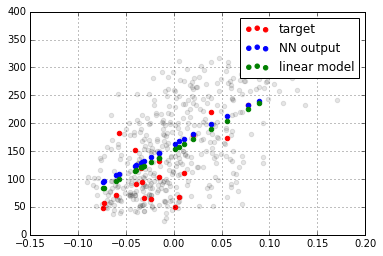

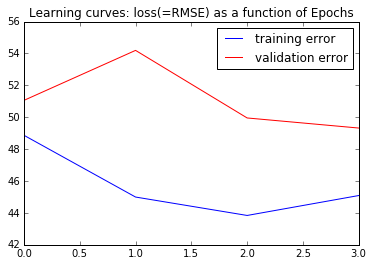

In [24]:
# Make the prediction
y_pred = [ nn1.activate([x]) for x in diabetes_X_test ]  

# Print the weights
def weight_connection(n):
    for mod in n.modules:
        for conn in n.connections[mod]:
            print conn
            for cc in range(len(conn.params)):
                print conn.whichBuffers(cc), conn.params[cc]
#weight_connection(nn1)

# And evaluate:

# Fitting error
plt.clf() 
plt.scatter(diabetes_X_train, diabetes_y_train,  color='black', alpha=0.1)
plt.scatter(diabetes_X_test, diabetes_y_test,  color='red', label = 'target')
plt.scatter(diabetes_X_test, y_pred, color = 'blue', label = 'NN output')  # NN
plt.scatter(diabetes_X_test, diabetes_y_pred_lin, color='green', label='linear model')  # benchmark
plt.legend()
plt.grid(True)
plt.show()

# Learning curves
plt.clf()
plt.plot(range(len(train_mse)), np.sqrt(train_mse), color='blue', label='training error')
plt.plot(range(len(validation_mse)), np.sqrt(validation_mse), color='red', label='validation error')
plt.title('Learning curves: loss(=RMSE) as a function of Epochs')
plt.legend()

### 3.2 PyBrain: Regression (diabetes dataset)

Similar as above (section 3.1), except here we are creating the feeforward neural network from scratch.

In [25]:
from pybrain.structure import FeedForwardNetwork, LinearLayer, SigmoidLayer, TanhLayer, BiasUnit, FullConnection
from pybrain.supervised.trainers import BackpropTrainer

nn2 = FeedForwardNetwork()

bias = False


## Constructing the input, hidden and output layers:

# In order to use them, we have to add them to the network:
nn2.addInputModule( LinearLayer(1, name = 'in') )      # inLayer
nn2.addModule( SigmoidLayer(5, name = 'hidden0') )     # hiddenLayer
nn2.addOutputModule( LinearLayer(1, name = 'out') )    # outLayer
if bias:
    nn2.addInputModule( BiasUnit(name = 'inbias') )        # bias for input layer
    nn2.addModule( BiasUnit(name = 'bias0') )              # bias for hidden layer

# As with modules, we have to explicitly add them to the network:
theta1 = FullConnection(nn2['in'], nn2['hidden0'])
theta2 = FullConnection(nn2['hidden0'], nn2['out'])
nn2.addConnection( theta1 )    # in_to_hidden connections
nn2.addConnection( theta2 )    # hidden_to_out connections
if bias:
    nn2.addConnection(FullConnection(nn2['inbias'], nn2['hidden0']))
    nn2.addConnection(FullConnection(nn2['bias0'], nn2['out']))

nn2.sortModules()     # making the MLP usable


# Build the dataset ***with bias units***
xvalues = diabetes_X_train[:,0]   # Should be normalized when lots of features
yvalues = diabetes_y_train
ds2 = SupervisedDataSet(1, 1)     # Dataset for Supervised Regression Training
# No need to add here the bias term to the feature matrix: it will be added in the training method
for x, y in zip(xvalues, yvalues):
    ds2.addSample((x), (y))       # ds.addSample((x1, ...., xn), (y)) # for each training example

# shows the nn2 weights
weight_connection(nn2)
    
# Train the NN
trainer = BackpropTrainer(nn2, ds2, learningrate = 0.01, weightdecay=0.01, momentum=0.0) #, verbose = True)
train_mse, validation_mse = trainer.trainUntilConvergence(maxEpochs = 20, continueEpochs=5, validationProportion=0.20)

<FullConnection 'FullConnection-15': 'in' -> 'hidden0'>
(0, 0) 0.444628730273
(0, 1) -0.758024150091
(0, 2) 0.465022163131
(0, 3) 0.918324403587
(0, 4) -1.02427564856
<FullConnection 'FullConnection-16': 'hidden0' -> 'out'>
(0, 0) -1.49459510247
(1, 0) 0.547377184957
(2, 0) 0.128170467515
(3, 0) 1.77372372223
(4, 0) 1.26133230475


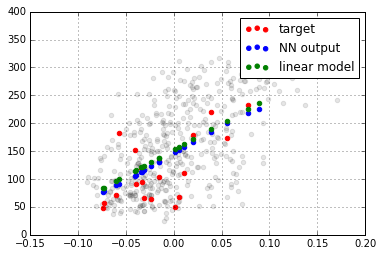

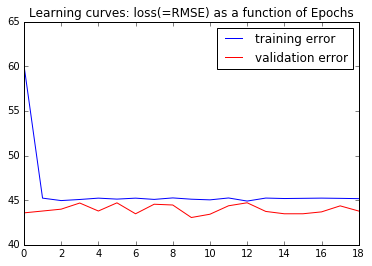

In [26]:
# Make the predictions
y_pred = [ nn2.activate([x]) for x in diabetes_X_test ]  

# Evaluate: 

# Plot outputs
plt.clf() 
plt.scatter(diabetes_X_train, diabetes_y_train,  color='black', alpha=0.1)
plt.scatter(diabetes_X_test, diabetes_y_test,  color='red', label = 'target')
plt.scatter(diabetes_X_test, y_pred, color = 'blue', label = 'NN output')
plt.scatter(diabetes_X_test, diabetes_y_pred_lin, color='green', label='linear model')  # benchmark
plt.legend()
plt.grid(True)
plt.show()

# Learning curves
plt.clf()
plt.plot(range(len(train_mse)), np.sqrt(train_mse), color='blue', label='training error')
plt.plot(range(len(validation_mse)), np.sqrt(validation_mse), color='red', label='validation error')
plt.title('Learning curves: loss(=RMSE) as a function of Epochs')
plt.legend()

### 3.2 PyBrain: Regression (sine function example)

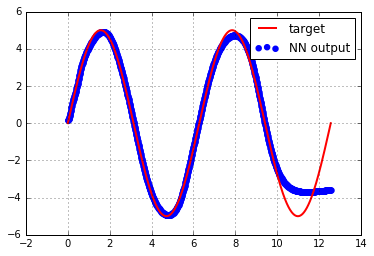

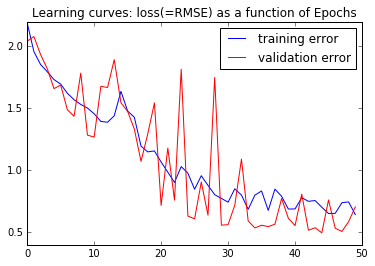

In [376]:
from pybrain.structure import SigmoidLayer, LinearLayer, TanhLayer
from pybrain.tools.shortcuts import buildNetwork
from pybrain.datasets import SupervisedDataSet
from pybrain.supervised.trainers import BackpropTrainer

# Build the dataset
xvalues = numpy.linspace(0, 2 * 2 * math.pi, 1001)  # should be normalized when lots of features
yvalues = 5 * numpy.sin(xvalues)
ds = SupervisedDataSet(1, 1)
for x, y in zip(xvalues, yvalues):
    ds.addSample((x,), (y,))

# Build the network
net = buildNetwork(1,  # 1 input node
                   30, # number of nodes in 1st hiddenlayer
                   30, # number of nodes in 1st hiddenlayer
                   1,  # 1 output node
                   bias = True,
                   hiddenclass = TanhLayer,  # better fit than sigmoid
                   outclass = LinearLayer)    # for regression

# Train the NN
trainer = BackpropTrainer(net, ds, learningrate = 0.0005, weightdecay=0.001, momentum=0.5) #, verbose = True)   
train_mse, validation_mse = trainer.trainUntilConvergence(maxEpochs = 50)

# Evaluate:

# Fitting error
plt.scatter(xvalues, [ net.activate([x]) for x in xvalues ], linewidth = 2,
           color = 'blue', label = 'NN output')
plt.plot(xvalues, yvalues, linewidth = 2, color = 'red', label = 'target')
plt.grid(True)
plt.legend()
plt.show()
#Learning curves
plt.clf()
plt.plot(range(len(train_mse)), np.sqrt(train_mse), color='blue', label='training error')
plt.plot(range(len(validation_mse)), np.sqrt(validation_mse), color='red', label='validation error')
plt.title('Learning curves: loss(=RMSE) as a function of Epochs')
plt.legend()

##### Note on some of the parameters

**weight decay** is the L2 regularization. 0 is no weight decay at all.

**learning rate** gives the ratio of which parameters are changed into the direction of the gradient. The learning rate decreases by lrdecay, which is used to to multiply the learning rate after each training step. The parameters are also adjusted with respect to momentum, which is the ratio by which the gradient of the last timestep is used.  

If **batchlearning** is set, the parameters are updated only at the end of each epoch. Default is False.  

## 4. Other packages

Initial analyses indicate that TensorFlow should bring also performance improvements compared to Theano, although no comprehensive benchmarks have yet been published.  
As the other packages are out already for a while, they have large, active communities and often additional supporting software (examples are the very useful wrappers around Theano like Lasagne, Keras and Blocks that provider higher level abstractions to its engine).